In [1]:
from zipfile import ZipFile
dataset = "/content/Celebrity Faces Dataset.zip"
with ZipFile(dataset, 'r') as zip:
  zip.extractall()
  print("The dataset is extracted.")

The dataset is extracted.


In [2]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Set up the directory path where your dataset is located
dataset_directory = '/content/Celebrity Faces Dataset'

# Function to load the dataset
def load_dataset(directory):
    images = []
    labels = []
    class_names = sorted(os.listdir(directory))  # Assumes each subdirectory is a class

    for i, class_name in enumerate(class_names):
        class_directory = os.path.join(directory, class_name)
        for filename in os.listdir(class_directory):
            if filename.endswith('.jpg') or filename.endswith('.png'):
                image_path = os.path.join(class_directory, filename)
                image = Image.open(image_path)
                image = image.resize((224, 224))  # Resize to 224x224 pixels
                image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
                images.append(image)
                labels.append(i)  # Store index of the class

    images = np.array(images)
    labels = np.array(labels)

    return images, labels, class_names

# Usage example
images, labels, class_names = load_dataset(dataset_directory)


Loaded images shape: (1799, 224, 224, 3)
Loaded labels shape: (1799,)


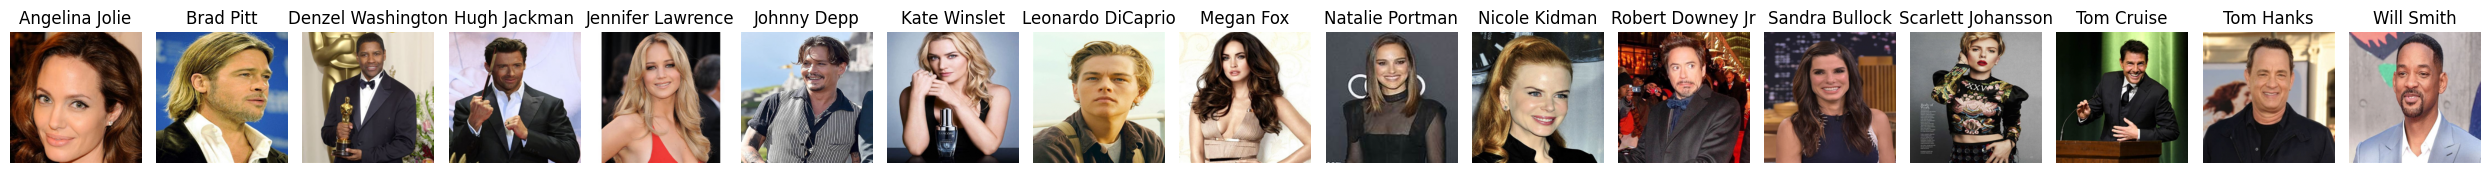

In [5]:
# Print shape of loaded data for verification
print("Loaded images shape:", images.shape)
print("Loaded labels shape:", labels.shape)

# Plotting example: Plot one example image from each class
num_classes = len(class_names)
fig, axes = plt.subplots(1, num_classes, figsize=(25, 5))

for i, class_name in enumerate(class_names):
    class_indices = np.where(labels == i)[0]
    example_image = images[class_indices[0]]
    axes[i].imshow(example_image)
    axes[i].set_title(class_name)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Function to create the CNN architecture
def create_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Example input shape (224x224 RGB images)
input_shape = (224, 224, 3)
num_classes = len(class_names)

# Create the model
model = create_model(input_shape, num_classes)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

In [7]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [8]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

# Print shape of split data for verification
print("Training images shape:", train_images.shape)
print("Validation images shape:", val_images.shape)

Training images shape: (1439, 224, 224, 3)
Validation images shape: (360, 224, 224, 3)


In [9]:
# Train the model
history = model.fit(train_images, train_labels,
                    batch_size=32,
                    epochs=20,
                    validation_data=(val_images, val_labels))

Epoch 1/20
45/45 [==============================] - 184s 4s/step - loss: 2.9377 - accuracy: 0.0987 - val_loss: 2.8461 - val_accuracy: 0.0472
Epoch 2/20
45/45 [==============================] - 180s 4s/step - loss: 2.7629 - accuracy: 0.1188 - val_loss: 2.7032 - val_accuracy: 0.1361
Epoch 3/20
45/45 [==============================] - 185s 4s/step - loss: 2.6033 - accuracy: 0.1772 - val_loss: 2.5784 - val_accuracy: 0.2111
Epoch 4/20
45/45 [==============================] - 183s 4s/step - loss: 2.3389 - accuracy: 0.2543 - val_loss: 2.4239 - val_accuracy: 0.2361
Epoch 5/20
45/45 [==============================] - 181s 4s/step - loss: 1.9528 - accuracy: 0.3871 - val_loss: 2.4107 - val_accuracy: 0.2250
Epoch 6/20
45/45 [==============================] - 179s 4s/step - loss: 1.5198 - accuracy: 0.5094 - val_loss: 2.4988 - val_accuracy: 0.2750
Epoch 7/20
45/45 [==============================] - 182s 4s/step - loss: 1.1562 - accuracy: 0.6053 - val_loss: 2.5655 - val_accuracy: 0.2722
Epoch 8/20
45

In [10]:
from sklearn.metrics import classification_report

# Evaluate the model
val_loss, val_acc = model.evaluate(val_images, val_labels)
print(f'Validation accuracy: {val_acc:.4f}')

# Predict labels for the validation set
val_predictions = model.predict(val_images)
val_pred_labels = np.argmax(val_predictions, axis=1)

# Generate classification report
report = classification_report(val_labels, val_pred_labels, target_names=class_names)
print(report)

12/12 [==============================] - 15s 1s/step - loss: 3.9013 - accuracy: 0.3028
Validation accuracy: 0.3028
12/12 [==============================] - 13s 1s/step
                    precision    recall  f1-score   support

    Angelina Jolie       0.17      0.12      0.14        17
         Brad Pitt       0.20      0.13      0.16        15
 Denzel Washington       0.25      0.24      0.24        21
      Hugh Jackman       0.06      0.04      0.05        26
 Jennifer Lawrence       0.55      0.26      0.35        23
       Johnny Depp       0.26      0.25      0.26        24
      Kate Winslet       0.25      0.14      0.18        21
 Leonardo DiCaprio       0.20      0.54      0.29        13
         Megan Fox       0.29      0.39      0.33        18
   Natalie Portman       0.58      0.35      0.44        20
     Nicole Kidman       0.28      0.35      0.31        20
  Robert Downey Jr       0.05      0.06      0.05        18
    Sandra Bullock       0.28      0.35      0.31  

In [14]:
print(history.history)

{'loss': [2.9377222061157227, 2.7628538608551025, 2.6033499240875244, 2.3389360904693604, 1.9527857303619385, 1.5197653770446777, 1.1562082767486572, 0.9062299728393555, 0.7795344591140747, 0.6816386580467224, 0.6102911829948425, 0.5356471538543701, 0.4613579213619232, 0.4185972511768341, 0.3743418753147125, 0.3699861764907837, 0.29681769013404846, 0.29092130064964294, 0.27645671367645264, 0.2663179636001587], 'accuracy': [0.09867963939905167, 0.11883252114057541, 0.1772063970565796, 0.25434330105781555, 0.38707435131073, 0.5093815326690674, 0.6052814722061157, 0.7039610743522644, 0.731758177280426, 0.7665045261383057, 0.8012508749961853, 0.8269631862640381, 0.8401668071746826, 0.8651841282844543, 0.8839471936225891, 0.8825573325157166, 0.8936761617660522, 0.9027101993560791, 0.9117442965507507, 0.9061848521232605], 'val_loss': [2.8460803031921387, 2.7032482624053955, 2.578397512435913, 2.4239392280578613, 2.4107141494750977, 2.4987587928771973, 2.5655412673950195, 2.7174389362335205, 

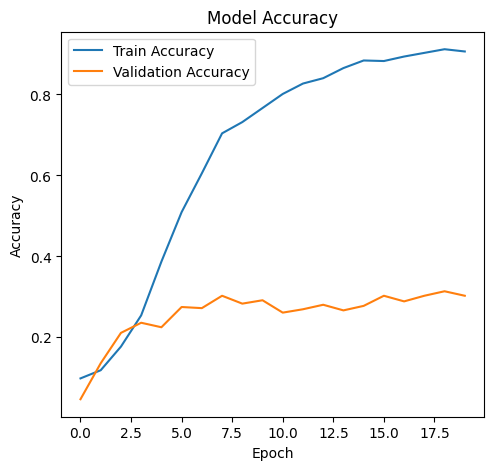

In [15]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

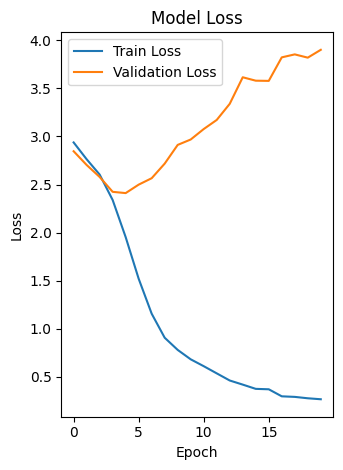

In [16]:
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [13]:
# Function to classify new images
def classify_new_image(model, image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    return predicted_class

# Example usage
new_image_path = '/content/Celebrity Faces Dataset/Robert Downey Jr/001_a51bb26a.jpg'
predicted_class = classify_new_image(model, new_image_path)
print(f'Predicted Class: {class_names[predicted_class]}')


1/1 [==============================] - 0s 54ms/step
Predicted Class: Robert Downey Jr


**Documentation and Analysis**

**Architecture Design Decisions:**

1. Convolutional Layers: Extract features from images using different filter sizes.
2. Pooling Layers: Reduce spatial dimensions and computation.
3. Dense Layers: Classify the extracted features.
4. Dropout Layer: Prevent overfitting.

**Hyperparameter Choices:**

1. Optimizer: Adam with a learning rate of 0.001.
2. Loss Function: Sparse Categorical Crossentropy for multi-class classification.
3. Batch Size: 32.
4. Epochs: 20.

**Training and Evaluation Procedures:**

1. Training: Model trained on the training set for 20 epochs.
2. Validation: Model evaluated on the validation set.

**Results and Analysis:**

1. The model's performance is measured using accuracy, precision, recall, and F1-score.
2. Validation accuracy and a detailed classification report provide insights into the model's performance.
